In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Klasyfikator binarny (cukrzyca Pima) w TensorFlow/Keras.
Spełnia wymagania zadania:
- pobranie/przygotowanie danych,
- podział 80/20,
- normalizacja (StandardScaler),
- sieć z >= 2 warstwami ukrytymi, ReLU, L2,
- sigmoid na wyjściu,
- binary_crossentropy + Adam, 50 epok, walidacja 20%,
- zapis wag do pliku H5,
- odtworzenie modelu i ewaluacja,
- wizualizacja przebiegów ACC/LOSS.

Uruchomienie (przykład):
    python pima_tensorflow_classifier.py --data diabetes.csv --epochs 50 --batch-size 32

Jeśli nie podasz --data, skrypt spróbuje pobrać zbiór z publicznego URL:
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv

Wymagania:
    pip install tensorflow pandas scikit-learn matplotlib requests
"""

'\nKlasyfikator binarny (cukrzyca Pima) w TensorFlow/Keras.\nSpełnia wymagania zadania:\n- pobranie/przygotowanie danych,\n- podział 80/20,\n- normalizacja (StandardScaler),\n- sieć z >= 2 warstwami ukrytymi, ReLU, L2,\n- sigmoid na wyjściu,\n- binary_crossentropy + Adam, 50 epok, walidacja 20%,\n- zapis wag do pliku H5,\n- odtworzenie modelu i ewaluacja,\n- wizualizacja przebiegów ACC/LOSS.\n\nUruchomienie (przykład):\n    python pima_tensorflow_classifier.py --data diabetes.csv --epochs 50 --batch-size 32\n\nJeśli nie podasz --data, skrypt spróbuje pobrać zbiór z publicznego URL:\n    https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv\n\nWymagania:\n    pip install tensorflow pandas scikit-learn matplotlib requests\n'

In [2]:
from __future__ import annotations

import argparse
import os
import sys
import io
import textwrap
from dataclasses import dataclass
from typing import Tuple, Optional

import numpy as np
import pandas as pd

# Importy narzędzi ML
try:
    import tensorflow as tf
    from tensorflow.keras import layers, regularizers, models
except Exception as e:
    raise SystemExit(
        "Brak TensorFlow. Zainstaluj: pip install tensorflow\n"
        f"Szczegóły: {e}"
    )

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [11]:
# Domyślny URL do wersji bez nagłówków (9 kolumn: 8 cech + 1 etykieta 0/1)
DEFAULT_URL = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"

# Oczekiwane nazwy kolumn (dla wersji z nagłówkami);
# jeśli wczytamy wersję bez nagłówków, nadamy je sami.
COLS = [
    "Pregnancies",
    "Glucose",
    "BloodPressure",
    "SkinThickness",
    "Insulin",
    "BMI",
    "DiabetesPedigreeFunction",
    "Age",
    "Outcome",
]


In [3]:
def maybe_download_to_df(path_or_url: Optional[str]) -> pd.DataFrame:
    """
    Wczytuje dane z lokalnej ścieżki lub z URL-a.
    - Obsługuje zarówno plik z nagłówkami (Outcome), jak i bez.
    - Jeśli path_or_url to None: używa DEFAULT_URL.
    """
    src = path_or_url or DEFAULT_URL

    if src.startswith("http://") or src.startswith("https://"):
        try:
            import requests
        except Exception:
            raise SystemExit("Aby pobrać dane z URL, zainstaluj pakiet 'requests'.")
        resp = requests.get(src, timeout=30)
        resp.raise_for_status()
        # Najpierw spróbujmy z header=None (format Brownlee), a jak nie wyjdzie to header=0
        try:
            df = pd.read_csv(io.StringIO(resp.text), header=None)
            if df.shape[1] == 9:
                df.columns = COLS
                return df
        except Exception:
            pass
        # Druga próba: załóż, że pierwszy wiersz to nagłówki
        df = pd.read_csv(io.StringIO(resp.text))
        if "Outcome" not in df.columns and df.shape[1] == 9:
            df.columns = COLS
        return df
    else:
        # Lokalny plik
        if not os.path.exists(src):
            raise SystemExit(f"Nie znaleziono pliku: {src}")
        # Spróbuj bez nagłówków
        try:
            df = pd.read_csv(src, header=None)
            if df.shape[1] == 9:
                df.columns = COLS
                return df
        except Exception:
            pass
        # Spróbuj z nagłówkiem
        df = pd.read_csv(src)
        if "Outcome" not in df.columns and df.shape[1] == 9:
            df.columns = COLS
        return df


In [4]:
@dataclass
class Dataset:
    X_train: np.ndarray
    X_test: np.ndarray
    y_train: np.ndarray
    y_test: np.ndarray
    scaler: StandardScaler

In [5]:
def prepare_data(
    df: pd.DataFrame,
    test_size: float = 0.2,
    random_state: int = 42,
) -> Dataset:
    """
    - Podział na cechy i etykiety,
    - Podział train/test (80/20),
    - Standaryzacja (fit na train, transform na train i test).
    """
    if "Outcome" not in df.columns:
        raise ValueError("W danych nie znaleziono kolumny 'Outcome' (etykieta).")

    X = df.drop(columns=["Outcome"]).values.astype(np.float32)
    y = df["Outcome"].values.astype(np.float32)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return Dataset(X_train, X_test, y_train, y_test, scaler)

In [6]:
def make_model(
    input_dim: int,
    l2_lambda: float = 1e-4,
    hidden_sizes: Tuple[int, int] = (32, 16),
) -> tf.keras.Model:
    """
    Buduje model MLP z >= 2 warstwami ukrytymi, ReLU + L2, sigmoid na wyjściu.
    """
    reg = regularizers.l2(l2_lambda)
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(hidden_sizes[0], activation="relu", kernel_regularizer=reg),
        layers.Dense(hidden_sizes[1], activation="relu", kernel_regularizer=reg),
        layers.Dense(1, activation="sigmoid"),
    ])
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [7]:
def plot_history(history: tf.keras.callbacks.History, out_prefix: str = "training"):
    """
    Rysuje i zapisuje przebiegi acc/loss do plików PNG.
    """
    hist = history.history

    # Accuracy
    plt.figure()
    plt.plot(hist.get("accuracy", []), label="train_acc")
    plt.plot(hist.get("val_accuracy", []), label="val_acc")
    plt.xlabel("Epoka")
    plt.ylabel("Dokładność")
    plt.title("Dokładność w trakcie treningu")
    plt.legend()
    plt.grid(True, linestyle=":")
    plt.tight_layout()
    acc_path = f"{out_prefix}_accuracy.png"
    plt.savefig(acc_path, dpi=150)
    print(f"Zapisano wykres dokładności: {acc_path}")

    # Loss
    plt.figure()
    plt.plot(hist.get("loss", []), label="train_loss")
    plt.plot(hist.get("val_loss", []), label="val_loss")
    plt.xlabel("Epoka")
    plt.ylabel("Strata")
    plt.title("Strata w trakcie treningu")
    plt.legend()
    plt.grid(True, linestyle=":")
    plt.tight_layout()
    loss_path = f"{out_prefix}_loss.png"
    plt.savefig(loss_path, dpi=150)
    print(f"Zapisano wykres straty: {loss_path}")

In [13]:
def main(argv=None):
    parser = argparse.ArgumentParser(
        description="Klasyfikator Pima Indians Diabetes w TensorFlow/Keras",
        formatter_class=argparse.RawDescriptionHelpFormatter,
        epilog=textwrap.dedent("""\
            Przykłady:
              python pima_tensorflow_classifier.py
              python pima_tensorflow_classifier.py --data diabetes.csv --epochs 50 --batch-size 32
        """),
    )
    parser.add_argument("--data", type=str, default=None, help="Ścieżka do CSV lub URL z danymi (opcjonalnie).")
    parser.add_argument("--epochs", type=int, default=50, help="Liczba epok (domyślnie: 50).")
    parser.add_argument("--batch-size", type=int, default=32, help="Rozmiar partii (domyślnie: 32).")
    parser.add_argument("--l2", type=float, default=1e-4, help="Współczynnik L2 (domyślnie: 1e-4).")
    parser.add_argument("--hidden", type=int, nargs=2, default=(32, 16), help="Rozmiary 2 warstw ukrytych (domyślnie: 32 16).")
    parser.add_argument("--val-split", type=float, default=0.2, help="Udział walidacji z danych treningowych (domyślnie: 0.2).")
    parser.add_argument("--seed", type=int, default=42, help="Seed losowości (domyślnie: 42).")
    args = parser.parse_args(argv)

    # Ustawienia powtarzalności
    np.random.seed(args.seed)
    tf.random.set_seed(args.seed)

    # (opcjonalnie) ogranicz zużycie pamięci GPU
    try:
        gpus = tf.config.list_physical_devices('GPU')
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except Exception:
        pass

    # Domyślny URL do wersji bez nagłówków (9 kolumn: 8 cech + 1 etykieta 0/1)
    DEFAULT_URL = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"

    # Oczekiwane nazwy kolumn (dla wersji z nagłówkami);
    # jeśli wczytamy wersję bez nagłówków, nadamy je sami.
    COLS = [
        "Pregnancies",
        "Glucose",
        "BloodPressure",
        "SkinThickness",
        "Insulin",
        "BMI",
        "DiabetesPedigreeFunction",
        "Age",
        "Outcome",
    ]

    print("Wczytywanie danych...")
    df = maybe_download_to_df(args.data)
    print(f"Dane: {df.shape[0]} wierszy, {df.shape[1]} kolumn.")

    dataset = prepare_data(df)
    X_train, X_test, y_train, y_test = dataset.X_train, dataset.X_test, dataset.y_train, dataset.y_test

    print("\nBudowa modelu...")
    model = make_model(input_dim=X_train.shape[1], l2_lambda=args.l2, hidden_sizes=tuple(args.hidden))
    model.summary(print_fn=lambda x: print("   " + x))

    print("\nTrening...")
    history = model.fit(
        X_train, y_train,
        validation_split=args.val_split,
        epochs=args.epochs,
        batch_size=args.batch_size,
        verbose=1,
    )

    # Ewaluacja modelu wytrenowanego
    print("\nEwaluacja (model wytrenowany):")
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"   Test loss: {loss:.4f} | Test acc: {acc:.4f}")

    # Zapis wag
    weights_path = "model_weights.weights.h5"
    model.save_weights(weights_path)
    print(f"Zapisano wagi do pliku: {weights_path}")

    # Odtworzenie modelu i ewaluacja
    print("\nOdtwarzanie modelu z wag...")
    re_model = make_model(input_dim=X_train.shape[1], l2_lambda=args.l2, hidden_sizes=tuple(args.hidden))
    re_model.load_weights(weights_path)

    print("Ewaluacja (model odtworzony):")
    re_loss, re_acc = re_model.evaluate(X_test, y_test, verbose=0)
    print(f"   Test loss (re): {re_loss:.4f} | Test acc (re): {re_acc:.4f}")

    # Krzywe uczenia
    print("\nRysowanie wykresów...")
    plot_history(history, out_prefix="training")

    # Dodatkowa metryka: dokładność via sklearn (po progowaniu 0.5)
    y_prob = model.predict(X_test, verbose=0).ravel()
    y_pred = (y_prob >= 0.5).astype(np.float32)
    sk_acc = accuracy_score(y_test, y_pred)
    print(f"\nDokładność (sklearn, próg 0.5): {sk_acc:.4f}")

    # Krótki opis tego, co pokazują wykresy
    print(textwrap.dedent("""\
        ---
        Opis wykresów:
        - 'training_accuracy.png': pokazuje jak rośnie (lub fluktuuje) dokładność na zbiorze treningowym
          oraz jak zachowuje się dokładność walidacyjna. Zbieżność obu krzywych i brak dużego rozjazdu
          sugerują umiarkowane dopasowanie.
        - 'training_loss.png': prezentuje zmiany funkcji straty w czasie. Spadek obu krzywych wskazuje
          na uczenie się modelu; jeśli strata walidacyjna zaczyna rosnąć, to znak możliwego przeuczenia.
        Wnioski należy wyciągać patrząc na trend obu par krzywych (train vs. val).
        ---
    """))

Wczytywanie danych...
Dane: 768 wierszy, 9 kolumn.

Budowa modelu...


   Model: "sequential_1"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘
 Total params: 833 (3.25 KB)
 Trainable params: 833 (3.25 KB)
 Non-trainable params: 0 (0.00 B)


Trening...
Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.6517 - loss: 0.6653 - val_accuracy: 0.6748 - val_loss: 0.6335
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


   Test loss (re): 0.5164 | Test acc (re): 0.7597

Rysowanie wykresów...
Zapisano wykres dokładności: training_accuracy.png
Zapisano wykres straty: training_loss.png

Dokładność (sklearn, próg 0.5): 0.7597
---
Opis wykresów:
- 'training_accuracy.png': pokazuje jak rośnie (lub fluktuuje) dokładność na zbiorze treningowym
  oraz jak zachowuje się dokładność walidacyjna. Zbieżność obu krzywych i brak dużego rozjazdu
  sugerują umiarkowane dopasowanie.
- 'training_loss.png': prezentuje zmiany funkcji straty w czasie. Spadek obu krzywych wskazuje
  na uczenie się modelu; jeśli strata walidacyjna zaczyna rosnąć, to znak możliwego przeuczenia.
Wnioski należy wyciągać patrząc na trend obu par krzywych (train vs. val).
---



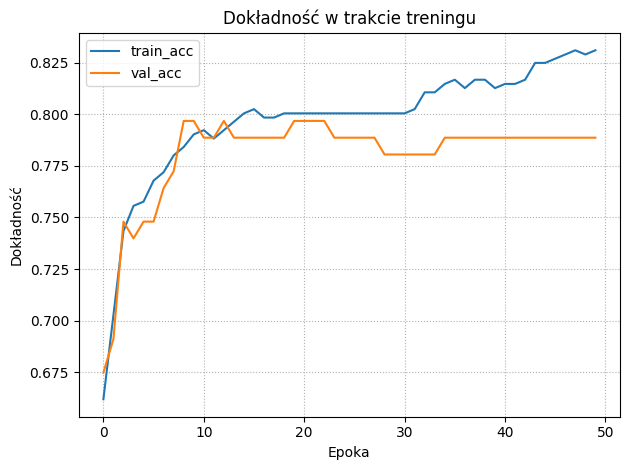

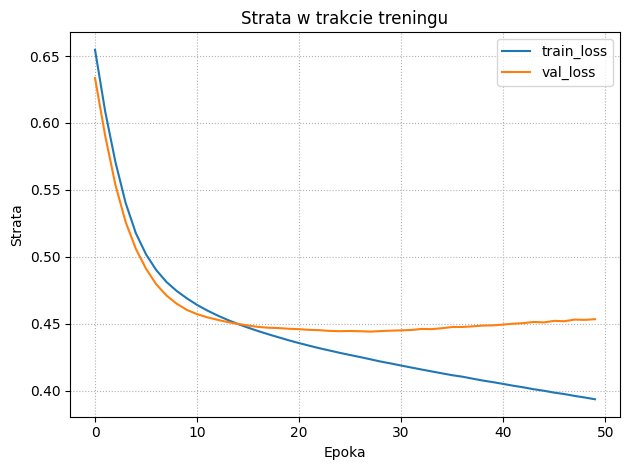

In [14]:
if __name__ == "__main__":
    # Pozwala wywołać skrypt też z notebooka: main([])
    main([])